In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns

# Processamento dos dados

Os dados vem com formatação em strings, portanto é necessário converter em dados numéricos.

Optei por transformar $X$ em $1$, $O$ em $-1$ e o espaço em branco em $0$

Quanto aos rótulos, por questões práticas, decidi 1 para positivo e -1 para negativo.
Essa decisão facilita e otimiza o processo de atualização dos pesos

In [2]:
# Utilizando a biblioteca fornecida por eles
tic_tac_toe_endgame = fetch_ucirepo(id=101)

# Pré processamento
X = tic_tac_toe_endgame.data.features.replace({'x': 1, 'o': -1, 'b': 0})
y = tic_tac_toe_endgame.data.targets.replace({'positive': 1, 'negative': -1}).squeeze()

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definição do modelo

Escolhi o AdaBoost por simplicidade e facilidade de implementação.

Nessa versão do AdaBoost, optei pela não reamostragem dos dados, somente pela atualização e salvamento dos pesos para predição. Dessa maneira, o algoritmo executa mais rapidamente, além de que mantém a acurácia: observei pelos meus estudos que não há diferenças significativas nos resultados em comparação ao método com reamostragem.

Os comentários no código descrevem as decisões pequenas de implementação, como a adição de um pequeno ruído no alpha, que representa a performance do modelo fraco, para evitar que ele seja igual a 0 ou 1, o que causaria problemas matemáticos.

Um detalhe importante dessa implementação é a definição dos modelos fracos como árvores de altura 1 e de no máximo 2 filhos. Isso faz com que os modelos fracos sejam os mais básicos possíveis, o que deixa a acurácia do modelo depender majoritariamente do número de modelos fracos usados, conforme solicitado no enunciado do trabalho.

Obviamente, se aumentasse a capacidade do modelo fraco, o modelo completo convergiria mais rapidamente com menos modelos fracos.

In [3]:
class AdaBoost:
    def __init__(self, num_trees):
        self.num_trees = num_trees

    def fit(self, X, y):
        self.models = []
        self.alphas = []

        n_samples, _ = X.shape
        
        # Iniciar pesos com valores iguais e proporcionais
        weights = np.full(n_samples, (1 / n_samples))
        
        for _ in range(self.num_trees):
            stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
            stump.fit(X, y, sample_weight=weights)
            stump_pred = stump.predict(X)
            
            error = weights[(stump_pred != y)].sum()
            # Add noise to prevent zero or one error
            error += 0.000053452
            
            alpha = 0.5 * np.log((1 - error) / error)
            # Update weights
            weights *= np.exp(-alpha * y * stump_pred)
            # Normalize weights
            weights /= weights.sum()
            
            # Store the weak model and its alpha
            self.models.append(stump)
            self.alphas.append(alpha)


    def predict(self, X):
        # A coluna se tornará o dado a ser previsto
        stump_preds = np.array([stump.predict(X) for stump in self.models])
        
        # Usar o alpha como peso nas predições dos modelos
        # Alpha grande = separou bem
        # O np.sign torna valores positivos e nulos 1 e negativos -1
        final_pred = np.sign(np.dot(self.alphas, stump_preds))
        return final_pred

### Teste básico do modelo

Com esse teste básico, é perceptível que o modelo funciona e aprendeu os dados bem

In [4]:
adaboost = AdaBoost(num_trees=50)
adaboost.fit(X_train, y_train)

train_preds = adaboost.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)

test_preds = adaboost.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Training accuracy: {train_accuracy}")
print(f"Testing accuracy: {test_accuracy}")

Training accuracy: 0.835509138381201
Testing accuracy: 0.8229166666666666


### Esquema rápido da demonstração de porque a atualização dos pesos está correta

In [5]:
weights = np.array([1/3, 1/3, 1/3])
y_correct = np.array([-1,1,-1])
preds= np.array([1,1,1])

error = weights[(preds != y_correct)].sum()
print(f'error: {error}')

print(f'preds * y: {preds * y_correct}')

# Se erro, aumento o peso
# Se acerto, diminuo o peso
print('Devo aumentar o peso: [True, False, True]')


# entao basta inverter o array preds * y_correct
print(f'preds * y invertido: {-(preds * y_correct)}')
print(f'bool -> preds * y invertido: {[False if x == -1 else True for x in -(preds * y_correct)]}')


error: 0.6666666666666666
preds * y: [-1  1 -1]
Devo aumentar o peso: [True, False, True]
preds * y invertido: [ 1 -1  1]
bool -> preds * y invertido: [True, False, True]


# Testes com o KFold

O KFold foi ajustado com 5 partições, conforme solicitado. Além disso, executei o teste para diferentes modelos, variando a quantidade de modelos fracos

In [6]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def kfold_test(num_trees):
    accuracies = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        adaboost = AdaBoost(num_trees)
        adaboost.fit(X_train, y_train)
        
        preds = adaboost.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        accuracies.append(accuracy)
        
    mean_accuracy = np.mean(accuracies)
    std_deviation = np.std(accuracies)
    
    return mean_accuracy, std_deviation

In [21]:
num_trees = [5, 10, 25, 50, 75, 100, 150, 200]

means = list()
stds = list()

for N in num_trees:
    mean, std = kfold_test(N)
    means.append(mean)
    stds.append(std)

# Resultados

Como esperado, à medida em que se aumenta o número de modelos fracos, o modelo tende a aprender melhor os dados. Caso haja muitos modelos fracos, o modelo tende a aprender maravilhosamente bem os dados de teste. No entanto, como imagino que os dados de teste foram produzidos e conjunto com os de treino, pode ser que esteja havendo um overfitting, mas não é muito claro.



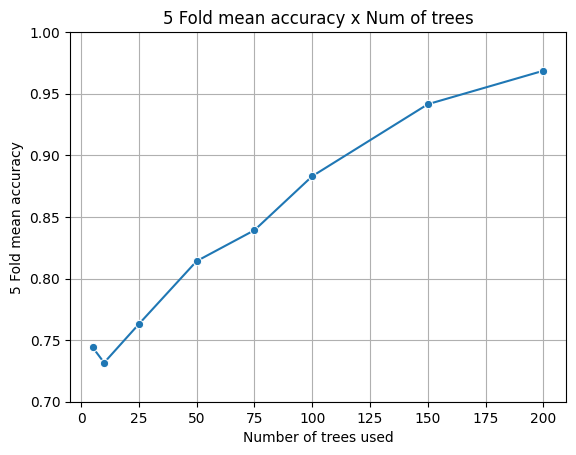

In [8]:
sns.lineplot(x=num_trees, y=means, marker='o')

plt.grid()

plt.yticks(np.arange(0.7, 1, 0.05))

plt.title('5 Fold mean accuracy x Num of trees')

plt.ylabel('5 Fold mean accuracy')
plt.xlabel('Number of trees used')

plt.show()

# Desvio padrão

Aparentemente, o modelo mais complexo, com mais modelos fracos, apresentou baixo viés e uma possível baixa variância, indicada pelo baixo desvio padrão. Esse resultado diz que ou os dados de treino e teste são muito parecidos ou que o modelo realmente performou muito bem.

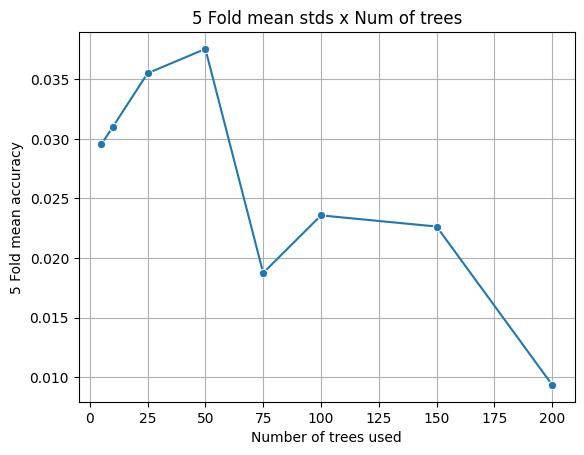

In [22]:
sns.lineplot(x=num_trees, y=stds, marker='o')

plt.grid()

plt.title('5 Fold mean std x Num of trees')

plt.ylabel('5 Fold mean std')
plt.xlabel('Number of trees used')

plt.show()

# Conclusão

Apesar da inconclusão relacionada ao dilema de viés e variância, é fato que o método de boosting aumentou a acurácia do modelo, de maneira a diminuir o viés apresentado nos modelos fracos.

O método é muito interessante e poderoso, além de possuir fácil implementação